In [2]:
%matplotlib inline
import numpy as np
import numba as nb
import cupy as qp
import operator as op
import time
import matplotlib as mpl
import pandas as pd
from pandas import HDFStore, DataFrame
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc
from math import sqrt
mysqrt= sqrt # as opposed to nb.sqrt
xp = np

In [4]:
# common numbers in float32 form to speed up calculations
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

In [5]:
# differential functions
@nb.njit(fastmath=True,parallel=True)
def d_dx(a, dx):
    return ( a[1:] - a[:-1] )*(np.float32(1)/dx) # ddx
@nb.njit(fastmath=True,parallel=True)
def d_dy(a, dy):
#     ddy = ( a[:,:-1] - a[:,1:] )*(np.float32(-1)/dy)
    return ( a[:,1:] - a[:,:-1] )*(np.float32(1)/dy)


# simple environments or initial conditions


def lingauss(shape, w, cx = 0, cy = 0, theta = 0, cutoff = 0.05, norm = False):#, win = (-2, 2)):
    """returns a 1d gaussian on a 2d array of shape 'shape'"""
    x = np.arange(0, shape[0])#linspace( win[0], win[1], shape[0] )
    y = np.arange(0, shape[1])#linspace( win[0], win[1], shape[1] )
    xx, yy = np.meshgrid(x, y, indexing='ij')
#     xy = (yy, xx)[ax]
    xy = np.cos(theta)*(xx-cx) + np.sin(theta)*(yy-cy) # lin comb of x, y, to rotate gaussian
    h = np.exp( - ( xy*xy ) / (2*w*w) )
    if norm:
        h = h / (np.sqrt(two*np.pi)*w)
    
    h -= cutoff
    h[np.less(h, zero)] = zero
    return (h)



# def planegauss(shape, win=((-2, 2), (-2, 2))):
#     """returns a 2d gaussian array of shape 'shape'"""
#     npx = np.linspace( win[0][0], win[0][1], shape[0] )
#     npy = np.linspace( win[1][0],win[1][1], shape[1] )
#     npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
#     h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) )
#     return (h)

# def planegauss(shape, wx, wy, cutoff = zero, norm = False):
#     """returns a 2d gaussian array of shape 'shape'
#         wx = width in x direction
#         wy = width in y direction
#         cutoff = height to set as zero
#     """
#     npx = np.arange(-shape[0]/2, shape[0]/2)
#     npy = np.arange(-shape[1]/2, shape[1]/2)
#     npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
#     h = np.exp( - ( npxx*npxx/(two*wx*wx) + npyy*npyy/(2*wy*wy) ) )
#     if norm:
#         h = h / (two*np.pi*wx*wy)
#     h[np.less(h, cutoff)] = zero
#     h -= cutoff
#     return (h)

def planegauss(shape, wx, wy, cx=0, cy=0, theta = 0, cutoff = 0.05, norm = False):
    h1 = lingauss(shape, wx, cx=cx, cy=cy, theta = theta, cutoff=cutoff, norm=norm)
    h2 = lingauss(shape, wy, cx=cx, cy=cy, theta = theta + np.pi/2, cutoff=cutoff, norm=norm)
    return h1*h2


def seismic(shape, width, length, a1 = 1, a2 = 1, cx=0, cy=0, theta=0, cutoff=0.05, norm=False):
    """returns simple seismic initial condition on array with shape 'shape'
        theta - angle from directly east seismic condition points, measured hill-to-valley
        length - length across (long direction)
        width - distance across hill-to-valley (short direction)"""
    offx = width*np.cos(theta)*0.5
    offy = width*np.sin(theta)*0.5
    h1 = a1*planegauss(shape, width/2, length, cx=cx+offx, cy=cy+offy, theta = theta, cutoff=cutoff, norm=norm) # 'hill'
    h2 = -a2*planegauss(shape, width/2, length, cx=cx-offx, cy=cy-offy, theta = theta, cutoff=cutoff, norm=norm) # 'valley'
    
    return h1+h2

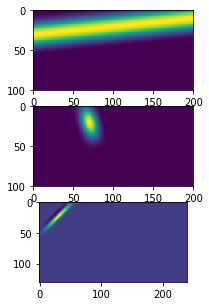

In [178]:
fig = plt.figure(11, figsize=(3, 5))

sub = plt.subplot(311)
plt.imshow(lingauss((100, 200), 10, cx = 30, theta=0.1))

sub = plt.subplot(312)
plt.imshow(planegauss((100, 200), 7, 14, cx = 20, cy = 70, theta=5))

sub = plt.subplot(313)
plt.imshow(seismic((130, 240), 5, 20, a1=4, a2=1, cx = 20, cy = 30, theta=np.pi/4))

In [179]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

class State(): # state
    def __init__(self, h, n, u, v, dx, dy, lat, lon):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat
        self.lon = lon
#         self.lats, self.lons = np.meshgrid(self.lat, self.lon)
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
    
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
#         self.calcDt()
        self.dt = np.min((np.min(self.dx), np.min(self.dy)))/(5*self.maxws)
        
        self.coriolis = np.float32(((2*2*np.pi*np.sin(self.lat*np.pi/180))/(24*3600))[:,np.newaxis]) # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
#     def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
#         dx = np.min(self.dx)
#         dy = np.min(self.dy)
#         self.dt = np.min((dx, dy))/(fudge*self.maxws)
props = op.itemgetter('h', 'n', 'u', 'v', 'dx', 'dy', 'lat', 'lon') # for grabbing the elements of a state
# def newstate(state):
#     return State(*(props(vars(state))))


# physics shallow water framework

## Class of objects to hold current state of an ocean grid 

Equations of motion
$$
\begin{align}
\frac{\partial \eta}{\partial t} & =
    -\frac{\partial  }{\partial x} \bigl( \left( \eta + h\right)u \bigr) 
    - \frac{\partial  }{\partial y}  \bigl( \left( \eta + h\right)v \bigr)\\  
\\
\frac{\partial u}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\
 & = +fv +\bigl( \kappa\nabla^{2}u - (u,v)\cdot\vec\nabla u \bigr)  
    - g\frac{\partial \eta}{\partial x} - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\  
& = +fv +\bigl( \kappa\frac{\partial^{2} u}{\partial x^{2}}
           +\kappa\frac{\partial^{2} u}{\partial y^{2}}
           -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial x}
            - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\
\\
\frac{\partial v}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\ 
    & = -fu + \bigl( \kappa\nabla^{2}v - (u,v)\cdot\vec\nabla v \bigr) 
    - g\frac{\partial \eta}{\partial y}
    - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\   
& = -fu+\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}
           +\kappa\frac{\partial^{2} v}{\partial y^{2}}
           -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial y}
           - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\           
\\
 \frac{\partial v}{\partial t} = &\\
         - g\frac{\partial \eta}{\partial y}&\\
         -fu&\\
         +\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}+\kappa\frac{\partial^{2} v}{\partial y^{2}}\bigr)\\
         -\bigl( u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}\bigr) &\\
         - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}&\\  
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant in time
- $\eta$ is the wave height above the calm ocean height
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$
- $\kappa$ is the viscous damping coefficient across the grid cell boundaries
- $\mu$ is the friction coeffecient


In [180]:
import numba as nb
from numba import cuda

zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

def dndt(h, n, u, v, dx, dy) :
    """change in n per timestep, by diff. equations"""
    hx = xp.empty(u.shape, dtype=n.dtype)
    hy = xp.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])*p5 # average
    hx[0] = zero
    hx[-1] = zero
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])*p5
    hy[:,0] = zero
    hy[:,-1] = zero
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
    return ( d_dx(hx, -dx)+d_dy(hy, -dy) )

    

@nb.njit
def dndt_drive_py(hpad, npad, u, v, dxpad, dypad, out):            
    for jx in nb.prange(0,     npad.shape[0]-2):
        for iy in range(0, npad.shape[1]-2):
            out[jx,iy] = dndt2(jx, iy, hpad, npad, u, v, dxpad, dypad)

 

            
@nb.njit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32)')        
def dndt2(jx, iy, hpad, npad, u, v, dx, dy) : # for individual vars
    """change in n per timestep, by diff. equations"""
    p5 = np.float32(0.5)
    jxpad = jx+1
    iypad = iy+1
    depth_jm0im0 = hpad[jxpad,  iypad  ]+npad[jxpad,    iypad]
    depth_jp1im0 = hpad[jxpad+1,iypad]  +npad[jxpad+1,iypad]
    depth_jm1im0 = hpad[jxpad-1,iypad]  +npad[jxpad-1,iypad]
    depth_jm0ip1 = hpad[jxpad,  iypad+1]+npad[jxpad,  iypad+1]
    depth_jm0im1 = hpad[jxpad,  iypad-1]+npad[jxpad,  iypad-1]
    
    hx_jp1 = u[jx+1,iy]*(depth_jm0im0 + depth_jp1im0)*p5
    hx_jm0 = u[jx,  iy]*(depth_jm1im0 + depth_jm0im0)*p5
    
    
    hy_ip1 = v[jx,iy+1]*(depth_jm0im0 + depth_jm0ip1)*p5
    hy_im0 = v[jx,iy  ]*(depth_jm0im1 + depth_jm0im0)*p5
    
    # assume u and v are zero on edge
    dhx = (hx_jp1-hx_jm0)/dx#[jx,iy]
    dhy = (hy_ip1-hy_im0)/dy#[jx,iy]

 
    return ( -dhx-dhy )
#@nb.njit(fastmath=True,parallel=True)    
def dudt(h, n, f, u, v, dx, dy, nu, mu=0.3) : # for individual vars
    g = np.float32(9.81)
    mu = np.float32(mu)
# def dudt(state):
#     f, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('coriolis', 'n', 'u', 'v', 'dx', 'dy')]
    dudt = xp.empty(u.shape, dtype=u.dtype) # x accel array
    grav = d_dx(n, -dx/g)
    dudt[1:-1] = grav
#     dudt[0] = grav[0]*2-grav[1] # assume outside map wave continues with constant slope
#     dudt[-1] = grav[-1]*2-grav[-2]
    
    
    # coriolis force
    vn = (v[:,1:]+v[:,:-1])*p5 # n shaped v
    
    fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
    fvn = (fn*vn) # product of coriolis and y vel.
    dudt[1:-1] += (fvn[1:]+fvn[:-1])*p5 # coriolis force
    dudt[0] += fvn[0]
    dudt[-1] += fvn[-1]
    
    
    # advection
    
    # advection in x direction
    dudx = d_dx(u, dx)
    
    dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*p5 # advection
#     dudt[0] -= u[0]*dudx[0]
#     dudt[-1] -= u[-1]*dudx[-1]
    
    # advection in y direction
    duy = xp.empty(u.shape, dtype=u.dtype)
    dudy = d_dy(u, dy)
    duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * p5
    duy[:,0] = dudy[:,0]
    duy[:,-1] = dudy[:, -1]
    dudt[1:-1] -= (vn[1:]+vn[:-1])*p5*duy[1:-1] # advection
#     dudt[0] -= vn[0]*duy[0]
#     dudt[-1] -=##### vn[-1]*duy[-1] # closest to applicable position
    
    
    #attenuation
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * una * np.sqrt(una*una + vna*vna) # attenuation
    dudt[1:-1] -= (attenu[1:] + attenu[:-1])*p5
    
    # viscous term
#     nu = np.float32(1000/dx)

#     ddux = d_dx(dudx, dx)
#     dduy = xp.empty(u.shape, dtype=u.dtype)
#     ddudy = d_dy(duy, dy)
#     dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * p5
#     dduy[:,0] = ddudy[:,0]
#     dduy[:,-1] = ddudy[:, -1]
#     dudt[1:-1] -= nu*(ddux+dduy[1:-1])
    
#     dudt[0] += nu*ddux[0]*dduy[0]
#     dudt[-1] += nu*ddux[-1]*dduy[-1]
    
    dudt[0] = zero
    dudt[-1] = zero # reflective boundaries
    dudt[:,0] = zero
    dudt[:,-1] = zero # reflective boundaries
    return ( dudt )









#@nb.njit(parallel=True,fastmath=True) 

def dudt2(jx, iy, h, n, f, u, v, dx, dy) : # for individual vars
    mu = np.float32(0.3)
    p5 = np.float32(0.5)
    one = np.float32(1)
    g=np.float32(9.81)
#     dudt = xp.empty(u.shape, dtype=u.dtype) # x accel array
#     grav = d_dx(n, -dx/p.g)
#     dudt[1:-1] = grav
    jxm1= jx-1
    iym1= iy-1
    jxp1= jx+1
    iyp1= iy+1
    jxm0= jx
    iym0= iy
    dudt = - g * ( n[jxm0, iym0] - n[jxm1, iym0] ) / dx
       
    # coriolis force
    
    vn_jm1 = (v[jxm1,iym0]+v[jxm1,iyp1])*p5
    vn_jm0 = (v[jxm0,iym0]+v[jxm0,iyp1])*p5
    
    vf_jm1im0 = f[jxm1,iym0]*vn_jm1  # techically the jx lookup on f is irrelevant
    vf_jm0im0 = f[jxm0,iym0]*vn_jm0
    
    dudt +=  (vf_jm0im0 + vf_jm1im0)*p5
               
    
    # advection
    
    # advection in x direction
    
    dudx_jp1 = (u[jxp1,iym0]-u[jxm0,iym0])/dx
    dudx_jm0 = (u[jxm0,iym0]-u[jxm1,iym0])/dx
    
    
    dudt -= u[jxm0,iym0]*(dudx_jp1+dudx_jm0)*p5
     
    # advection in y direction
    
    dudy_ip1 = (u[jxm0,iyp1]-u[jxm0,iym0])/dy
    dudy_im0 = (u[jxm0,iym0]-u[jxm0,iym1])/dy
    
    vu = (vn_jm1+vn_jm0)*p5
    
    dudt -= vu*(dudy_ip1 + dudy_im0)*p5 # wrong? multiply in other order?
    
    
    #attenuation
    
    un_jm1 = (u[jxm1,iym0]+u[jxm0,iym0])*p5   #  n centered
    vn_jm1 = (v[jxm1,iym0]+v[jxm1,iyp1])*p5
    
    
    un_jm0 = (u[jxm0,iym0]+u[jxp1,iym0])*p5
    vn_jm0 = (v[jxm0,iym0]+v[jxm0,iyp1])*p5
    
    attenu_jm1 = one/(h[jxm1,iym0]+n[jxm1,iym0]) * mu * un_jm1 * mysqrt(un_jm1*un_jm1 + vn_jm1*vn_jm1) # attenuation
    attenu_jm0 = one/(h[jxm0,iym0]+n[jxm0,iym0]) * mu * un_jm0 * mysqrt(un_jm0*un_jm0 + vn_jm0*vn_jm0) # attenuation
    
    dudt -= (attenu_jm1 + attenu_jm0)*p5
    
    # viscous term
    #
    
#     dudt[0] = zero
#     dudt[-1] = zero # reflective boundaries
#     dudt[:,0] = zero
#     dudt[:,-1] = zero # reflective boundaries
    return ( dudt )

device_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32)',device=True,fastmath=True)


dudt2_cuda =device_compiler_cuda(dudt2)

device_compiler_numba = nb.njit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32)',parallel=True,fastmath=True)
#dudt2_numba =dudt2

dudt2_numba = device_compiler_numba (dudt2)

#@nb.njit(parallel=True,fastmath=True)
#@nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:])')
def dudt_drive_cuda(h, n, f, u, v, dx, dy, out):
    iy ,jx= nb.cuda.grid(2)
    #print(jx,iy,jx == 0 or  jx == out.shape[0]-1,out.shape[1]>iy, iy == 0 or  iy == out.shape[1]-1,out.shape[0]>jx)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dudt2_cuda(jx,iy,h,n,f,u,v,dx,dy)
    else:  # could lose this since we don't care! 
       if jx == 0 or  jx == out.shape[0]-1:
           if out.shape[1]>iy:
                   out[jx,iy] = np.float32(0.0)
       elif iy == 0 or  iy == out.shape[1]-1:
           if out.shape[0]>jx:
                   out[jx,iy] = np.float32(0.0)
compiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:])',fastmath=True)

dudt_drive_cuda=compiler(dudt_drive_cuda)

def dudt_drive_py(h, n, f, u, v, dx, dy, out):   
    for jx in nb.prange(1, u.shape[0]-1):
        for iy in range(1, u.shape[1]-1):
            out[jx,iy] = dudt2_numba(jx,iy,h,n,f,u,v,dx,dy)


dudt_drive_numba = nb.njit(dudt_drive_py,parallel=True, fastmath=True)




def dvdt(h, n, f, u, v, dx, dy, nu, mu=0.3) :
    mu = np.float32(mu)
    dvdt = xp.empty(v.shape, dtype=v.dtype) # x accel array
    
    # gravity
    grav = d_dy(n, -dy/p.g)
    dvdt[:,1:-1] = grav
    
    # coriolis force
    un = (u[1:]+u[:-1])*p5 # n-shaped u
    fun = (f*un)
    dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5
    
    # advection in y direction
    dvdy = d_dy(v, dy)
    dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*p5
    
    # advection in x direction
    dvx = xp.empty(v.shape, dtype=v.dtype)
    dvdx = d_dx(v, dx)
    dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * p5
    dvx[0] = dvdx[0]
    dvx[-1] = dvdx[-1]
    dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*p5*dvx[:,1:-1]
    
    # attenuation
    una = (u[1:]+u[:-1]) * p5
    vna = (v[:,1:]+v[:,:-1])*p5
    attenu = 1/(h+n) * mu * vna * np.sqrt(una*una + vna*vna)
    dvdt[:,1:-1] -= (attenu[:,1:] + attenu[:,:-1])*p5
    
    dvdt[0] = zero
    dvdt[-1] = zero # boundaries
    dvdt[:,0] = zero
    dvdt[:,-1] = zero # boundaries
    return dvdt



    # DVDT viscous term
#     nu = np.float32(dy/1000) # nu given as argument

#     ddvy = d_dy(dvdy, dy)
#     ddvx = xp.empty(v.shape, dtype=v.dtype)
#     ddvdx = d_dx(dvx, dx)
#     ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * p5
#     ddvx[0] = ddvdx[0]
#     ddvx[-1] = ddvdx[-1]
#     dvdt[:,1:-1] -= nu*(ddvy+ddvx[:,1:-1])

#     dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
#     dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]

In [181]:
import time
Nx=3000
Ny=4000

hpad = np.array(10+np.random.rand(Nx+2, Ny+2),dtype=np.float32)
npad =  np.array(np.random.rand(Nx+2, Ny+2),dtype=np.float32)
f = np.zeros((Nx, Ny),dtype=np.float32)  

u =  np.array(np.random.rand(Nx+1, Ny),dtype=np.float32)
v =  np.array(np.random.rand(Nx, Ny+1),dtype=np.float32)
# dx =  np.array(3.1*np.ones((Nx, Ny)),dtype=np.float32)
# dy =  np.array(3.1*np.ones((Nx, Ny)),dtype=np.float32)
dx = 3.1
dy = 3.2
h = hpad[1:-1,1:-1].copy()
n = npad[1:-1,1:-1].copy()

u[0,:] = 0
u[-1,:] = 0
u[:,0] = 0
u[:,-1] = 0
v[0,:] = 0
v[-1,:] = 0
v[:,0] = 0
v[:,-1] = 0

# print (h)
uout = np.zeros((Nx+1, Ny),dtype=np.float32)

ch = nb.cuda.to_device(h)
cn = nb.cuda.to_device(n)
cu = nb.cuda.to_device(u)
cv = nb.cuda.to_device(v)
cout = nb.cuda.to_device(uout)
cf = nb.cuda.to_device(f)


print ("moo")
print (dudt_drive_cuda._func.get().attrs)
maxthreads= dudt_drive_cuda._func.get().attrs.maxthreads
blockdim = (32,min(32,maxthreads//32))
gridx = ( (cout.shape[1]+blockdim[0])//blockdim[0],(cout.shape[0]+blockdim[1])//blockdim[1])

print ("grid",gridx,"block",blockdim)
dudt_drive_cuda[gridx,blockdim](ch, cn, cf,cu, cv, dx, dy, cout)
dudt_drive_numba(h, n, f, u, v, dx, dy, uout)  # warmup
uout[:] = cout.copy_to_host()


uold = dudt(h, n, f, u, v, dx, dy, 0, 0.3)
nb.cuda.synchronize()
#dudt_drive_numba(h, n, f, u, v, dx, dy, uout)


def foo_numba():
    for i in range(10):
        dudt_drive_numba(h, n, f, u, v, dx, dy, uout)
    return uout



def foo_cuda():
    for i in range(10):
        dudt_drive_cuda[gridx,(32,32)](ch, cn, cf,cu, cv, dx, dy, cout)
    nb.cuda.synchronize()
    return cout.copy_to_host()


def foo_old():
    for i in range(10):
        tmp =dudt(h, n, f, u, v, dx, dy, 0, 0.3)
    return tmp

for i,ff in enumerate((foo_old,foo_numba,foo_cuda,)):
    t = time.perf_counter()
    foo= ff()
    t = (time.perf_counter()-t)/10.0
    if (i==0): t0=t
    print (ff.__name__,'time',t,"rel time factor",t0/t)
    print ('diff',np.max(uold-foo), np.min(uold-foo))
    if (Nx*Ny<8194):
        plt.figure(i)
        plt.imshow(foo)
        plt.title(ff.__name__)
        plt.figure(i+10)
        plt.imshow(foo-uold)
        plt.colorbar()
plt.show()

#if (Nx*Ny<8194):
#    plt.figure(2)
#    plt.imshow(uold)
#    plt.figure(3)
#    plt.imshow(uout)
#    plt.figure(4)
#    plt.imshow(uold-uout)
#    plt.colorbar()
%timeit foo_old()
%timeit foo_numba()
%timeit foo_cuda()




nold = dndt(h, n, u, v, dx, dy)
nnout = np.zeros((Nx, Ny))
dndt_drive_py(hpad, npad, u, v, dx, dy, nnout)
if (False):
    plt.figure(6)
    plt.imshow(nold)
    plt.figure(7)
    plt.imshow(nnout)
    plt.figure(8)

    print(nold.shape,nnout.shape)
    plt.imshow(nold-nnout)

    plt.colorbar()
print(np.max(nold-nnout),"\n", np.min(np.abs(nold-nnout)))    

# print(nold,"\n",nnout)
# print (nold-nnout)

moo
FuncAttr(regs=44, shared=0, local=0, const=0, maxthreads=1024)
grid (126, 94) block (32, 32)
foo_old time 0.2876765059016179 rel time factor 1.0
diff 0.0 0.0
foo_numba time 0.052788550697732715 rel time factor 5.4496003792347665
diff 9.536743e-07 -9.536743e-07
foo_cuda time 0.0026341668970417233 rel time factor 109.20967317017397
diff 9.536743e-07 -9.536743e-07
2.47 s ± 48.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
413 ms ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.9 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.76837158203125e-07 
 0.0


In [182]:

def forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, borders, beta=0, mu=0.3): # forward euler and forward/backward timestep
    """
        beta = 0 forward euler timestep
        beta = 1 forward-backward timestep
    """
    beta = np.float32(beta)
    mu = np.float32(mu)
    
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dudt(h, n, f, u, v, dx, dy, mu) )*dt
    v1 = v + ( beta*dvdt(h, n1, f, u, v, dx, dy, mu) +  (one-beta)*dvdt(h, n, f, u, v, dx, dy, mu) )*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # handle any land in the simulation
    n1, u1, v1 = border(n1, u1, v1, 15, borders)
    return n1, u1, v1

def fbfeedback(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, borders, beta=1/3, eps=2/3, mu=0.3): # forward backward feedback timestep
    beta = np.float32(beta)
    eps = np.float32(eps)
    mu = np.float32(mu)
    n1g, u1g, v1g = forward(h, n, u, v, f, dt, dx, dy, nu, doland, coastx, borders, beta, mu) # forward-backward first guess
    #feedback on guess
    
    n1 = n+p5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u+p5*(eps*dudt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dudt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dudt(h, n, f, u, v, dx, dy, nu, mu))*dt
    v1 = v+p5*(eps*dvdt(h, n1, f, u, v, dx, dy, nu, mu)+(one-eps)*dvdt(h, n1g, f, u1g, v1g, dx, dy, nu, mu)+dvdt(h, n, f, u, v, dx, dy, nu, mu))*dt
    
    u1, v1 = doland(h, u1, v1, coastx) # how to handle land/coast
    n1, u1, v1 = border(n1, u1, v1, 15, borders)
    return n1, u1, v1




def timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, borders, mu):
    return fbfeedback(h, n, u, v, f, dt, dx, dy, nu, land, coastx, borders, mu) # switch which integrator/timestep is in use
# def timestep(state): return fbfeedback(state, land) # which integrator/timestep is in use

#

In [183]:
def land(h, u, v, coastx): # how to handle land/above water area
    #boundaries / land
#     coastx = xp.less(h, thresh) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = zero
    (u[:-1])[coastx] = zero # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = zero
    (v[:,:-1])[coastx] = zero
    return (u, v)

def border(n, u, v, margwidth=15, alph=np.array([0.95, 0.95, 0.95, 0.5])):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    
    # attenuate off edges to minimize reflections
    n[0:margwidth] *= alph[0]
    u[0:margwidth] *= alph[0]
    v[0:margwidth] *= alph[0]
    
    n[-1:-margwidth-1:-1] *= alph[1]
    u[-1:-margwidth-1:-1] *= alph[1]
    v[-1:-margwidth-1:-1] *= alph[1]
    
    n[:,0:margwidth] *= alph[2]
    u[:,0:margwidth] *= alph[2]
    v[:,0:margwidth] *= alph[2]
    
    n[:,-1:-margwidth-1:-1] *= alph[3]
    u[:,-1:-margwidth-1:-1] *= alph[3]
    v[:,-1:-margwidth-1:-1] *= alph[3]
    
    return n, u, v

In [184]:
def returnnuv (h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr): return n, u, v
def simulate(initstate, t, nttname = '', bounds = np.array([0.95, 0.95, 0.95, 0.95]), mu=0.3, colormap='seismic', drive=None): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (numpy memmap of n through time) numpy array,
            maxn (the maximum value of n over the duration at each point) numpy array,
            minn (the minimum value of n over the duration at each point) numpy array,
            timemax (the number of seconds until the maximum height at each point) numpy array
    """
    if drive == None:
        drive = returnnuv
    h, n, u, v, f, dx, dy, dt = [qp.asnumpy(initstate.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'coriolis', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    nu = (dx+dy)/1000
    #     state = initstate
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    
#     nshdf = HDFStore('etaevolvestorage')
    
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.memmap('eed_' + nttname, dtype='float32', mode='w+', shape=(itrs,)+n.shape)
    #np.zeros((itrs,)+n.shape, dtype=n.dtype)
#     animframes = np.array([(plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),)])
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
    timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    
    coastx = xp.less(h, landthresh) # where the reflective condition is enforced on the coast
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            n, u, v = timestep(h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu) # pushes n, u, v one step into the future
            ntt[itr] = n
            
#             nshdf.put(str(itr), DataFrame(n)) # save n value to nshdf with key the iteration number
#             animframes = np.append(animframes, (plt.imshow(qp.asnumpy(n), vmin=-mmax, vmax=mmax, cmap=colormap),))
#             np.save('etaevolvestorage', ntt)
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records
            minn = np.min((n, minn), axis=0)
#             timemax[np.greater(n, maxn)] = itr*dt
#             if (itr%ff = 0):
            n, u, v = drive(h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr) # drive
        
    except:
        print('timestep #:' + str(itr))
        ntt.flush()
#         return animframes, maxn, minn, timemax
        raise Exception('error occured in simulate, printed timestep#')
    ntt.flush()
#     nshdf.close()
    print('simulation complete')
    return ntt, maxn, minn#, timemax # return surface height through time and maximum heights

# verification

simulation complete


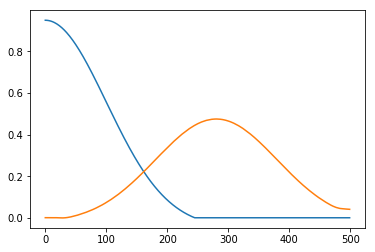

..

-0.10283605399815789 0.11



----------------------------------------------------------------------
Ran 2 tests in 3.630s

OK


In [185]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 100 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = np.float32(10000)
        self.n = 1*lingauss(self.size, 100, cy=500, theta=np.pi/2) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.11 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(5)
        plt.clf()
#         plt.subplot(2, 1, 1)
#         plt.imshow(ar1)
#         plt.subplot(2, 1, 2)
#         plt.imshow(ar2)
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
        self.simdata = simulate(self.testStart, self.dur, bounds=np.array([1, 1, 1, 1]), mu=0)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        self.testFrames = self.simdata[0]
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

In [186]:
simpletestcase = {
    'h': 1000*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100), 10, 10, 50, 50),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
simpleState = State(**simpletestcase)

In [187]:
simpleframes, simpleMax = simulate(simpleState, 100, bounds=np.array([0.95, 0.95, 0.95, 1]))[0:2]#, simpleMax, simpleMin, simpleAT
#                                                                      T     B     L    R
# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

/home/rrs/anaconda3/envs/shallowwater/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in add


simulation complete


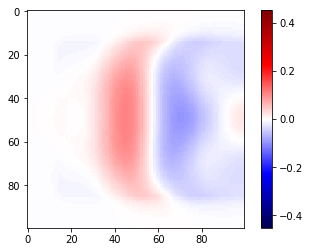

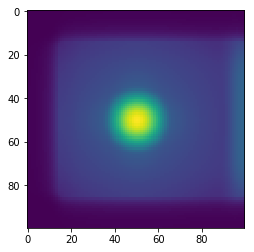

In [188]:
fig = plt.figure(25)
mmax = np.max(np.abs(simpleframes))/2
simpleart = [(plt.imshow(simplef, vmin=-mmax, vmax=mmax, cmap='seismic'),) for simplef in simpleframes[::5]]
anim = animation.ArtistAnimation(fig, simpleart, interval=50, blit=True, repeat_delay=200)
anim.save('../results/simpleplop2.mp4')
plt.colorbar()
plt.show()
fig = plt.figure(27)
plt.imshow(simpleMax)

In [193]:
friccase = {
    'h': 1000*np.ones((100, 100), dtype=np.float),
    'n': planegauss((100, 100), 10, 10),
    'u': np.zeros((101, 100)),
    'v': np.zeros((100, 101)),
    'dx': 100,
    'dy': 100,
    'lat': np.zeros((100,)),
    'lon': np.zeros((100,))
}
fricState = State(**friccase)

In [194]:
fricframes = simulate(fricState, 100)[0]#, simpleMax, simpleMin, simpleAT
nofricframes = simulate(fricState, 100, mu=0.0)[0]
# fig = plt.figure(23)
# plt.imshow(simpleframes[50])v

/home/rrs/anaconda3/envs/shallowwater/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in add


simulation complete
simulation complete


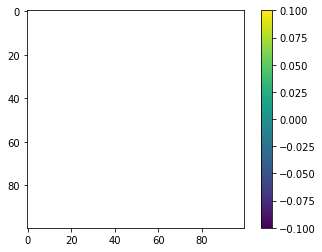

0.0


In [195]:
fig = plt.figure(25)
fricdif = (fricframes-nofricframes)/(np.abs(fricframes)+np.abs(nofricframes)+1E-10)
fricart = [(plt.imshow(fricf, vmin=np.min(fricdif), vmax=np.max(fricdif)),) for fricf in fricdif]
anim = animation.ArtistAnimation(fig, fricart, interval=50, blit=True, repeat_delay=0)
plt.colorbar()
plt.show()
print(np.mean(fricdif))

In [196]:
slope = {
    'h': np.pad(np.linspace(5000, 5, 800)[:,np.newaxis], ((50, 50), (1, 1)), mode='edge'),
    'n': np.zeros((900, 3)),#planegauss((200, 200), 10, 10, 50, 50),
    'u': np.zeros((901, 3)),
    'v': np.zeros((900, 4)),
    'dx': 40,
    'dy': 40,
    'lat': np.zeros((900,)),
    'lon': np.zeros((900,))
}
print(slope['h'].shape)
slopeState = State(**slope)

(900, 3)


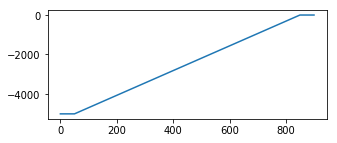

In [197]:
plt.figure(29, figsize=(5, 2))
plt.plot(-slopeState.h[:,1])
plt.plot()
# plt.colorbar()
plt.show()

In [198]:
def driver(h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr):
    n[0] = np.sin(itr*dt/8)[np.newaxis]
#     u[0] = np.cos(itr*dt/10)[np.newaxis]
    return n, u, v
slopeframes, slopeMax = simulate(slopeState, 500, bounds=np.array([1, 0.95, 1, 1]), drive=driver)[0:2]#, simpleMax, simpleMin, simpleAT

simulation complete


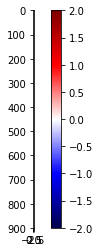

In [199]:
fig = plt.figure(30)
mmax = np.max(np.abs(slopeframes))/2
slopeart = [(plt.imshow(slopef, vmin=-2, vmax=2, cmap='seismic'),) for slopef in slopeframes[::5]]
anim = animation.ArtistAnimation(fig, slopeart, interval=20, blit=True, repeat_delay=200)
plt.colorbar()
plt.show()

# fig = plt.figure(29)
# plt.imshow(slopeMax)

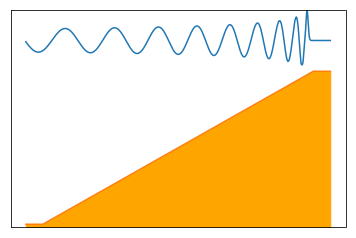

In [200]:
mmax = np.max(np.abs(slopeframes))/2

fig, ax = plt.subplots()

x = np.arange(0, slopeframes.shape[1])
line, = ax.plot(x,slopeframes[0][:,1])
ax.plot(-slopeState.h[:,1])
# ax.fill_between(x, -2000, slopeframes[0][:,100], color='blue')
ax.fill_between(x, -5100, -slopeState.h[:,1], color='orange')
plt.ylim(-5100, 2000)
ax.set_xticks([],[])
ax.set_yticks([],[])

def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(1000+450*slopeframes[5*i][:,1])  # update the data.
#     ax.fill_between(x, 0, slopeframes[2*i][:,100], color='blue')
    return line,

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=5, blit=True, save_count=2500, repeat=True, repeat_delay=500)
ani.save('../results/waveramp.mp4')
plt.show()

# indonesian tsunami

In [201]:

class indone2004():
    event = {
        'lat': 3.316,
        'lon': 95.854
    } # source of the tsunami
    
    dlat = 111000 # latitude degree to meters
    psize = (dlat*30*np.cos(22.5*np.pi/180), dlat*15) # physical size of area
    size = (2500, 1250) # grid squares (dx) # lat, lon

    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters

    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    
    rxy = (8, 16)
    lat = bath.variables['lat'][:]#[latin]
    lon = bath.variables['lon'][:]
    latr = (np.abs(lat-event['lat']+rxy[1]).argmin(), np.abs(lat-event['lat']-rxy[1]).argmin())
    lonr = (np.abs(lon-event['lon']+rxy[0]).argmin(), np.abs(lon-event['lon']-rxy[0]).argmin())
    latin = np.linspace(latr[0], latr[1], size[0], dtype=int)
    lonin = np.linspace(lonr[0], lonr[1], size[1], dtype=int) # indexes of the bathymetry dataset we need
    lat = bath.variables['lat'][latin]
    lon = bath.variables['lon'][lonin]
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)

    n = np.zeros(size)

    evinlat = np.argmin(np.abs(lat - event['lat']))
    evinlon = np.argmin(np.abs(lon - event['lon'])) # the index of the closest value to the correct longitude
    rady = 1+2*(int(25000/dy)//2) # number of indicies across the disturbance is
    radx = 1+2*(int(25000/dx)//2) # modified to be odd, so a point lands on the max of the gaussian
#     evpatch = \

#     evpatch = \
    n[evinlat-rady:evinlat+rady, evinlon-radx:evinlon+radx] = \
    50*planegauss((2*rady, 2*radx))

    u = np.zeros((size[0]+1, size[1]+0))
    v = np.zeros((size[0]+0, size[1]+1))

indonesia = State(*(props(vars(indone2004))))

KeyboardInterrupt: 

In [ ]:
seasurface = qp.asnumpy(indonesia.n)#np.empty(qp.asnumpy(indonesia.n).shape)
# seasurface[::-1] = qp.asnumpy(indonesia.n)
bathymetry = -qp.asnumpy(indonesia.h)


plt.figure(116)
plt.title('initial conditions of indonesia simulation')

# plt.subplot(121)
a1 = plt.imshow(seasurface, cmap='seismic', vmin=-np.max(seasurface), vmax=np.max(seasurface))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height (m)')

# plt.subplot(222)
a2 = plt.contour(-bathymetry, cmap='Greys')
tt2 = plt.title('bathymetry')
# cb2 = plt.colorbar()
# cb2.set_label('ocean depth (m)')

# plt.subplot(122)
# # a3 = vect()
# tt3 = plt.title('inital velocity (m/s)')


In [132]:
indosim = simulate(indonesia, 2500)
indot = indosim[0]
maxindo = indosim[1]
minindo = indosim[2]
tmindo = indosim[3]

KeyboardInterrupt: 

masq = np.zeros(qp.asnumpy(indonesia.h).shape, dtype=qp.asnumpy(indonesia.h).dtype)
runuplocs = np.array([(5.251, 95.253), (5.452, 95.242), (5.389, 95.960), (2.575, 96.269), (4.208, 96.040)])
radx = masq.shape[0]//100
rady = masq.shape[1]//100
for runuploc in runuplocs:
    arglat, arglon = np.argmin(np.abs(indonesia.lat-runuploc[0])), np.argmin(np.abs(indonesia.lon-runuploc[1])) # gat the index location of this event
    masq[arglat-radx:arglat+radx, arglon-rady:arglon+rady] = 1 # make a small blip around the locatoin

plt.figure(123)
plt.contour(masq)
plt.show()

In [14]:
# shallowWater/data/2004indonesiarunups.txt

In [15]:
indof = np.transpose(indot, (0, 1, 2))
print(indof.shape)
maxt = np.max(indof,axis=(1,2))
print(maxt.shape)
imaxt = np.float32(1.0/maxt)
# plt.figure(888)
# plt.semilogy(maxt)
# plt.show()
norm_indof = indof*imaxt[:,np.newaxis,np.newaxis]

h = qp.asnumpy(indonesia.h)
# ht = np.transpose(h)
ht = h

(120, 2500, 1250)
(120,)


<IPython.core.display.Javascript object>


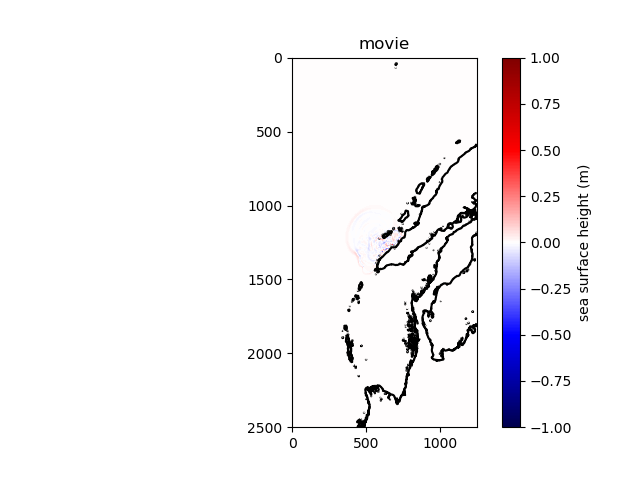

In [16]:
fig = plt.figure(122)

# plt.subplot(1, 3, 1)
plt.title('movie')
# f = genframes(norm_indof*0.3, frames=np.linspace(0, norm_indof.shape[0]-1, 300, dtype=int))
indoArts = [(plt.imshow(normindoframe, cmap='seismic', vmin=-np.max(normindoframe), vmax=np.max(normindoframe)),) for normindoframe in norm_indof]
indoAnim = animation.ArtistAnimation(fig, indoArts)
cb = plt.colorbar()
cbtt = cb.set_label('sea surface height (m)')


coast = plt.contour(ht, colors='black', levels=1)#, levels=3)
# locmask = plt.contour(masq, colors='green', levels=2)

<IPython.core.display.Javascript object>


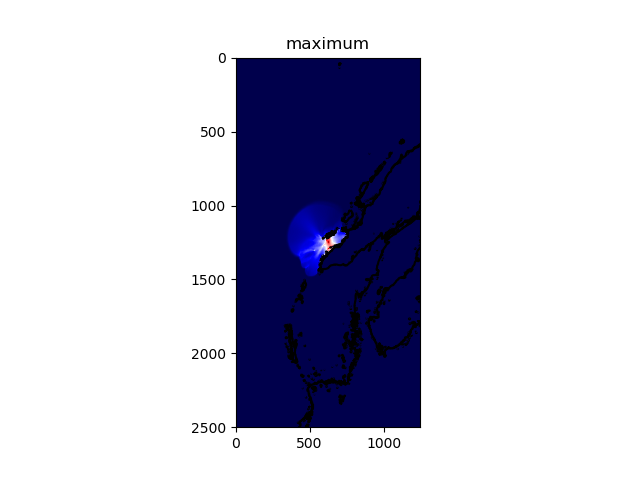

In [17]:
fig = plt.figure(124)
plt.title('maximum')
plt.imshow(maxindo+1, cmap='seismic', norm=mpl.colors.LogNorm())
# plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

<IPython.core.display.Javascript object>


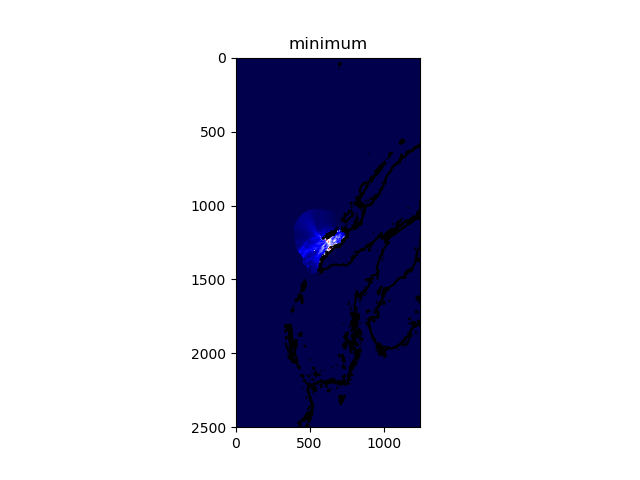

In [18]:
fig = plt.figure(126)
plt.title('minimum')
plt.imshow(1-minindo, cmap='seismic', norm=mpl.colors.LogNorm())
    # plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

plt.show()

# comparing indonesia sim to real data

In [19]:
import pandas as pd

ff = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
#with open('~rrs/shallowWater/data/2004indonesiarunups.txt','r') as f:
#     txt = f.read()
ff   

,Item,Item.1,Country,State,Name,Latitude,Longitude,DistanceFromSource,IWDay,IWHr,...,MWHr,MMWMin,MaxWaterHeight,MaxInundationDistance,Type,Per,1st,Mtn,z1,z2
0,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.43300,95.23600,245.0,NaN,NaN,...,NaN,NaN,26.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.56900,95.34100,257.0,NaN,NaN,...,NaN,NaN,6.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.60200,95.38300,260.0,NaN,NaN,...,NaN,NaN,10.70,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.61000,95.39700,260.0,NaN,NaN,...,NaN,NaN,11.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.28600,95.24400,229.0,NaN,NaN,...,NaN,NaN,11.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN
5,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64900,95.41600,264.0,NaN,NaN,...,NaN,NaN,4.20,NaN,5.0,NaN,NaN,NaN,NaN,NaN
6,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,4.90,NaN,5.0,NaN,NaN,NaN,NaN,NaN
7,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.62100,95.39800,261.0,NaN,NaN,...,NaN,NaN,6.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
8,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64700,95.41500,264.0,NaN,NaN,...,NaN,NaN,7.00,NaN,5.0,NaN,NaN,NaN,NaN,NaN
9,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,7.10,NaN,5.0,NaN,NaN,NaN,NaN,NaN


In [20]:
# includes the whole world
allruns = pd.read_csv('~rrs/shallowWater/data/al2004indorunups2.txt', sep='\t')
allruns = allruns.dropna(how='any',subset=['Latitude', 'Longitude', 'TTHr', 'TTMin', 'MaxWaterHeight'])
allruns = allruns.loc[:,['Latitude','Longitude','MaxWaterHeight','DistanceFromSource','TTHr','TTMin','Name']]

In [21]:
# import data from file
indorut = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
indoevents = list(indorut.transpose().to_dict().values()) # list of dicts of events' properties
indoevents

[{'Item': '*',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.433,
  'Longitude': 95.236,
  'DistanceFromSource': 245.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 26.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.569,
  'Longitude': 95.341,
  'DistanceFromSource': 257.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 6.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUM

In [22]:
# sort the events by proximity to the source
# indoevents.sort(key = lambda event: np.sqrt((indone2004.event['lat'] - event['Latitude'])**2 + (indone2004.event['lat'] - event['Longitude'])**2))
indoevents.sort(key = lambda event: event['DistanceFromSource'])

In [23]:
# simindomaxh = np.array([], dtype=np.float32) # the list of the maximum height that occured at each location
# for event in indoevents: # get the maximum water height at each location in the sim in the order given to us
# #     print(event)
#     evlat = event['Latitude'] # the latitude of the measurement
#     evlon = event['Longitude'] # "  longitude " "       "
#     argevlat = np.argmin(np.abs(indonesia.lat-evlat)) # the array index with latitude closest to point
#     argevlon = np.argmin(np.abs(indonesia.lon-evlon)) # the array index with longitude closest to point
#     mh = maxindo[argevlat, argevlon] # the maximum height at this point
#     if (argevlat == 0 or argevlon == 0): # if the point is out of the map so it just returns the edge
#         mh = 0 # ignore the value at the edge 
#     simindomaxh = np.append(simindomaxh, mh)

# list of indexes maximum height at the location of each event
# simindomaxh = [np.max(\
#                       maxindo[\
#                               np.argmin(np.abs(indonesia.lon-event['Longitude'])), \
#                               np.argmin(np.abs(indonesia.lat-event['Latitude']))]) \
#                for event in indoevents]
def simindomaxhgenerator():
    for event in indoevents:
        ilon = np.argmin(np.abs(indonesia.lon-event['Longitude']))
        ilat = np.argmin(np.abs(indonesia.lat-event['Latitude']))
        rad = 20
        ilon = np.max((ilon, rad))
        ilat = np.max((ilat, rad))
        
#         print(maxindo.shape, maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad].shape, [ilon-rad,ilon+rad, ilat-rad,ilat+rad])
        try:
            mh = np.max(maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad])
        except (ValueError): # when the section is entirely off the map so it returns an empty array
            mh = -1
        yield mh

simindomaxh = np.asarray(list(simindomaxhgenerator()))
simindomaxh

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
        0.00000000e+00, -1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -

In [24]:
indomaxheights = np.array([event['MaxWaterHeight'] for event in indoevents]) # the max water heights of each of the events in the order they are listed

In [25]:
#doesn't work - times not recorded
# indotimemh = [event['TTHr']*3600+event['TTMin']*60 for event in indoevents] # a 2d map of the time it took to get there
# indotimemh

<IPython.core.display.Javascript object>


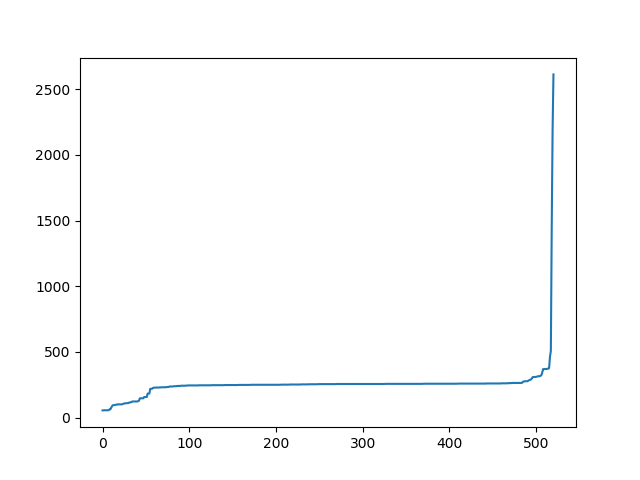

In [26]:
plt.figure(133)
plt.plot([event['DistanceFromSource'] for event in indoevents])
plt.show()

<IPython.core.display.Javascript object>


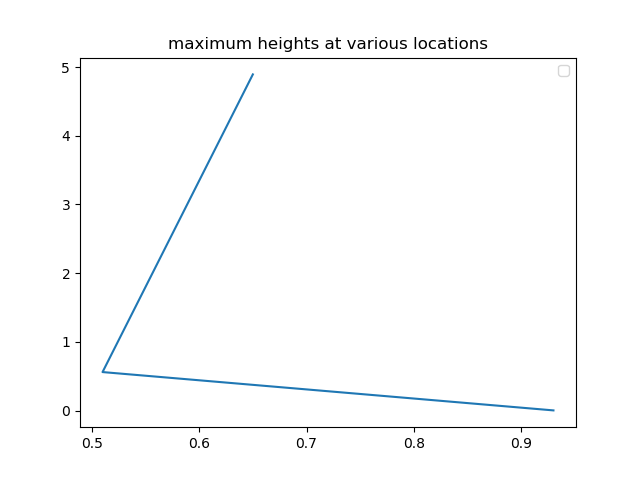

No handles with labels found to put in legend.


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [27]:
plt.figure(236)
datamap = np.greater(simindomaxh, 0)
print(datamap)
plt.title('maximum heights at various locations')

plt.plot(indomaxheights[datamap], simindomaxh[datamap])

# plt.plot(indomaxheights[datamap], label='measurement') # real data of max water heights

# plt.plot(simindomaxh[datamap], label='simulation') # simulation max water heights in the same order

plt.legend()
plt.show()

# Palu event

### functions for placing disturbance at lat lon location

### setting up instance for palu

In [202]:
palu = {}
latran = (-1.2, 0.2) # latitude range map covers
lonran = (118.7, 121) # longitude range map covers

# calculate height of map  11100*lat degrees = meters
# calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
# use lon degree size of average latitude
realsize = (111000*(latran[1]-latran[0]),\
               111000*(lonran[1]-lonran[0])\
                  *np.cos((latran[1]-latran[0])/2))# h, w of map in meters
    
size = (700, 1150) # grid size of the map lat, lon


palu['dx'] = np.single(realsize[1]/size[1], dtype=np.float32)
palu['dy'] = np.single(realsize[0]/size[0], dtype=np.float32)

# read in bathymetry data
bathdata = nc.Dataset('../data/bathymetry.nc','r')
bathlat = bathdata.variables['lat']
bathlon = bathdata.variables['lon']
#calculate indexes of bathymetry dataset we need
bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                        np.argmin(np.abs(bathlat[:]-latran[1])),\
                        size[0], dtype=int)
bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                        np.argmin(np.abs(bathlon[:]-lonran[1])),\
                        size[1], dtype=int)
# print(bathlatix, bathlonix)
palu['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix])
palu['lat'] = np.asarray(bathlat[bathlatix])
palu['lon'] = np.asarray(bathlon[bathlonix])

palu['n'] = np.zeros(size, dtype=np.float32)
palu['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
palu['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)
paluState = State(**palu)

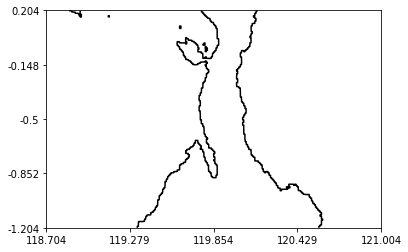

In [203]:

fig = plt.figure(166)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))

### create array of the lat, lon position of the multiple testing events

In [204]:
# rad = 0.4 # radius in latitude degrees
# center = (-0.63,119.75) # point events are equidistant from
# dtheta = np.pi/8 # how far the events are from each other
# firsttheta = np.pi/2 # the first events angle from east
# eventcount = 6 # how many events to simulate

#(center[0] + rad*np.sin( firsttheta + evnum*dtheta ),\
                      # center[1] + rad*np.cos( firsttheta + evnum*dtheta ))\

dist = 33000 #17000 # m from mouth of palu bay
center = (-0.63, 119.75) # point events are equidistant from
startang = np.pi/4 # angle of first event
endang = np.pi+0.01 # angle of last event
dang = np.pi/16 # change in angle

argcenter = (np.argmin(np.abs(paluState.lat-center[0])), \
             np.argmin(np.abs(paluState.lon-center[1]))) # the index of the center point
argdist = int(dist/paluState.dx)

print(argdist, argcenter)

seiswidth = int(30000/9/paluState.dx)
seislength = int(60000/9/paluState.dx)


initns = np.array([seismic(paluState.n.shape, \
                              width = seiswidth, \
                              length = seislength, \
                              a1 = 4, a2 = 1, \
                              cx = argcenter[0]-np.cos(ang)*argdist, \
                              cy = argcenter[1]-np.sin(ang)*argdist, \
                              theta = ang+np.pi) \
                      for ang in np.arange(startang, endang, dang)]) # array of the lat, lon positions of each event

194 (286, 525)


### plot the initial events

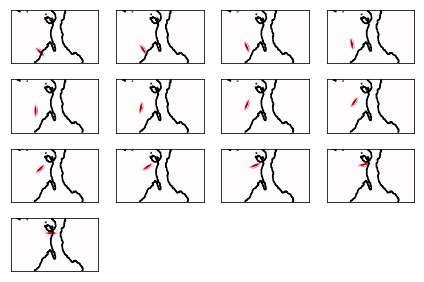

In [205]:

spnum = 1
spcount = initns.shape[0]
plt.figure(176)
mmax = np.max(np.abs(initns))
for initn in initns:
    plt.subplot(int(np.int(np.sqrt(spcount)))+1, spcount/int(np.int(np.sqrt(spcount))), spnum)
    
    # sea surface height
    plt.imshow(initn[::-1], cmap='seismic', vmax=mmax, vmin=-mmax)
    
    # coast
    coast = plt.contour(palu['h'][::-1], levels=1, colors='black')
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    plt.xticks([], [])
    plt.yticks([], [])
    
    spnum += 1
plt.tight_layout()

### run each event and collect output (max, min, ntt-[memmap]) in array

In [ ]:
paluState = State(**palu)

eventcount = initns.shape[0]

maxes = np.zeros((eventcount,) + paluState.n.shape)#np.array([])
# mins = np.zeros((eventcount,) + paluState.shape)#np.array([])
# nttmm = np.array([])

evnum = 0 # keep track of which event number were on

for initn in initns:
    initd = dict(palu) # create copy of Palu init conditons
    initd['n'] = initn # with the initial SSH of this specific event
    initstate = State(**initd) # turn into instance of State class
    
    maxn = simulate(initstate, 2500, nttname = 'palseis-' + str(evnum))[1] # simulate it
    
    print('finished event ' + str(evnum)) # show progress
    
    maxes[evnum] = maxn # record data for this event
#     mins[evnum] = minn
#     maxes[evnum] = maxn
    
    evnum += 1
print('all done')
# save results
np.save('../results/palumaxheights', maxes)

simulation complete
finished event 0
simulation complete
finished event 1


In [ ]:
paluState = State(**palu)

eventcount = initns.shape[0]

maxes = np.zeros((eventcount,) + paluState.n.shape)#np.array([])
# mins = np.zeros((eventcount,) + paluState.shape)#np.array([])
# nttmm = np.array([])

evnum = 0 # keep track of which event number were on

for initn in initns:
    initd = dict(palu) # create copy of Palu init conditons
    initd['n'] = initn # with the initial SSH of this specific event
    initstate = State(**initd) # turn into instance of State class
    
    maxn = simulate2(initstate, 2500, nttname = 'palseis-' + str(evnum))[1] # simulate it
    
    print('finished event ' + str(evnum)) # show progress
    
    maxes[evnum] = maxn # record data for this event
#     mins[evnum] = minn
#     maxes[evnum] = maxn
    
    evnum += 1
print('all done')
# save results
np.save('../results/palumaxheights', maxes)

In [ ]:
# or load previous results
maxes = np.load('../results/palumaxheights.npy')

### display outcomes of each event

In [ ]:
print('maxes: ',maxes.shape)
print('n: ', paluState.n.shape)

In [ ]:

stfignum = 117 # the neighborhood of figure numbers in use

fignum = 0 # specific figure

#window including just palu bay
pb1 = 150
pb2 = 280
pb3 = 520
pb4 = 600

mmax = np.max(maxes[:,pb1:pb2,pb3:pb4]) # true max of maxes
imax = np.max(initns) # true max of initial SSH's

for initn in initns: # display initial SSH of each event
    fig = plt.figure(stfignum+fignum) # start new figures
    
#     plt.subplot(1, 2, 1)
    plt.imshow(initn[::-1], cmap='seismic', vmax = imax, vmin=-imax)# plot initial condition
    coast = plt.contour(palu['h'][::-1]-1.5, levels=1, colors='black') # plot coast
    
    # use latitude, longitude tick markers
    xtixks = plt.xticks(np.linspace(0, palu['h'][::-1].shape[1], 5),\
               np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, palu['h'][::-1].shape[0], 5),\
               np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
#     plt.xticks([], [])
#     plt.yticks([], [])
    
    plt.savefig('../results/palu-init-' + str(fignum)) # download image
    
    fignum+=1 # next figure
 # repeat of last with colorbar
plt.figure(stfignum+fignum)
plt.imshow(initns[-1], cmap='seismic', vmax=imax, vmin=-imax)
plt.colorbar()
plt.savefig('../results/palu-init-cb')
fignum+=1
for maxn in maxes: # display maximum heights in palu bay of each event
    fig = plt.figure(stfignum+fignum) # start new figure
    
#     plt.subplot(1, 2, 2)
    plt.imshow(maxn[pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0) # show max height image
    coast = plt.contour(palu['h'][pb2:pb1:-1, pb3:pb4]-1.5, levels=1, colors='black') # the coast
    
    # use latitude, longitude tickmarks
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.savefig('../results/palu-max-' + str(fignum)) # download image
    
    fignum += 1 # next figure
# repeat of last event, but with colorbar
plt.figure(stfignum+fignum)
plt.imshow(maxes[-1][pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0)
plt.colorbar()
plt.savefig('../results/palu-max-cb')

<IPython.core.display.Javascript object>


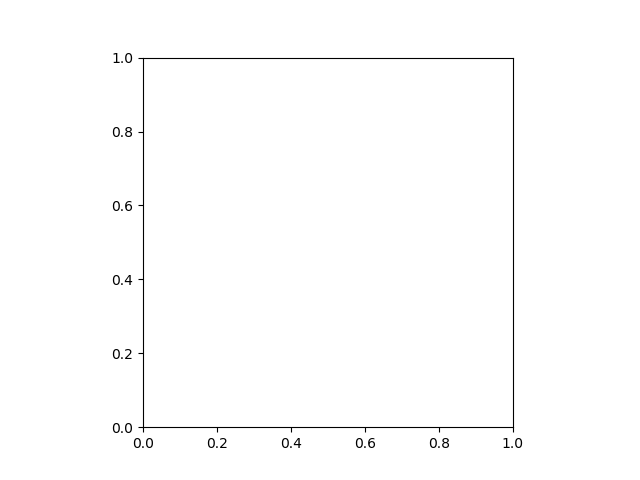

0


TypeError: Invalid dimensions for image data

In [316]:
fig = plt.figure(150)
ntt = np.memmap('eed_')
print(ntt[0])
mmax = np.max(maxes[-1])/2
arts = [(plt.imshow(n, vmin=mmax, vmax=mmax, cmap='seismic'),) for n in ntt]
anim = animation.ArtistAnimation(fig, arts)
plt.show()

In [201]:
# create a case
def gencase(latst, laten, lonst, lonen, tsulat, tsulon, tsutheta, tsusize):
    case = {}
    latran = (latst, laten) # latitude range map covers
    lonran = (lonst, lonen) # longitude range map covers

    # calculate height of map  11100*lat degrees = meters
    # calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
    # use lon degree size of average latitude
    realsize = (111000*(latran[1]-latran[0]),\
                   111000*(lonran[1]-lonran[0])\
                      *np.cos((latran[1]-latran[0])/2))# h, w of map in meters

    size = (100, 100) # grid size of the map lat, lon


    case['dx'] = np.single(realsize[1]/size[1], dtype=np.float32)
    case['dy'] = np.single(realsize[0]/size[0], dtype=np.float32)

    # read in bathymetry data
    bathdata = nc.Dataset('../data/bathymetry.nc','r')
    bathlat = bathdata.variables['lat']
    bathlon = bathdata.variables['lon']
    #calculate indexes of bathymetry dataset we need
    bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                            np.argmin(np.abs(bathlat[:]-latran[1])),\
                            size[0], dtype=int)
    
    bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                            np.argmin(np.abs(bathlon[:]-lonran[1])),\
                            size[1], dtype=int)
    # print(bathlatix, bathlonix)
    case['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix])
    case['lat'] = np.asarray(bathlat[bathlatix])
    case['lon'] = np.asarray(bathlon[bathlonix])

    case['n'] = seismic(size, 20, 50, tsusize, tsusize/3,\
                        cx=np.argmin(np.abs(case['lat']-tsulat)),\
                        cy=np.argmin(np.abs(case['lon']-tsulon)),\
                        theta=tsutheta)
    case['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
    case['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)
    caseState = State(**case)

    # plot bathymetry and initial SSH to confirm
    fig = plt.figure()
    coast = plt.contour(caseState.h, levels=1, colors='black')
    ssh = plt.imshow(caseState.n, cmap='seismic', vmin=-tsusize, vmax=tsusize)
    xtixks = plt.xticks(np.linspace(0, caseState.h.shape[1], 5),\
               np.round(np.linspace(caseState.lon[0], caseState.lon[-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, caseState.h.shape[0], 5),\
               np.round(np.linspace(caseState.lat[0], caseState.lat[-1], 5), 3))
    
    return caseState

enter the first latitude coordinate: -1.2
enter the last latitude coordinate: 0.8
enter the first longitude coordinate: 119
enter the last longitude coordinate: 121
enter the latitude of the initial tsunami: 0
enter the longitude of the initial tsunami: 119.5
enter the angle of the tsunami: 1
enter the height (meters) of the tsunami: 5


<IPython.core.display.Javascript object>


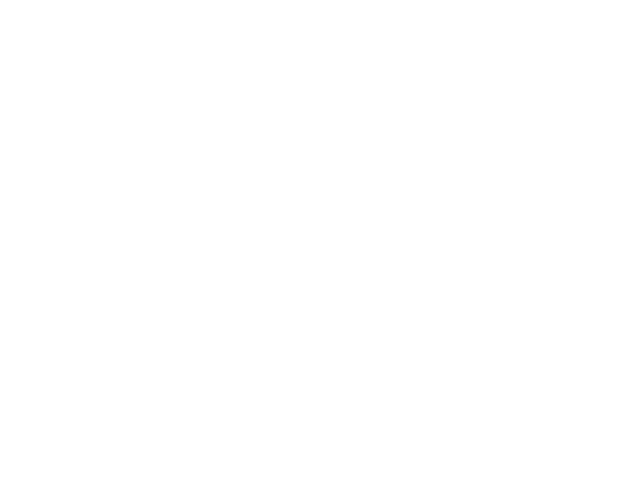

does this figure look right (y/n)?y
running simulation...


KeyError: 'h'

In [206]:
latst = float(input('enter the first latitude coordinate: '))
latend = float(input('enter the last latitude coordinate: '))
lonst = float(input('enter the first longitude coordinate: '))
lonend = float(input('enter the last longitude coordinate: '))
tsulat = float(input('enter the latitude of the initial tsunami: '))
tsulon = float(input('enter the longitude of the initial tsunami: '))
tsutheta = float(input('enter the angle of the tsunami: '))
tsusize = float(input('enter the height (meters) of the tsunami: '))
caseSt = gencase(latst, latend, lonst, lonend, tsulat, tsulon, tsutheta, tsusize)
if input('does this figure look right (y/n)?') == 'y':
    print('running simulation...')
    caseTT, caseMax, caseMin = simulate(gencase, 100, nttname='usercase')

In [192]:
seismic?

In [167]:
memmapar = np.memmap('memmaptest', dtype='float32', mode='w+', shape=(500, 500, 500))
numpyar = np.zeros((500, 500,500), dtype=np.float32)
%timeit memmapar[0] = testdata
%timeit numpyar[0] = testdata

27.6 µs ± 353 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
26.6 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
